<a href="https://colab.research.google.com/github/Kushagratandon12/Diabetic_retinopathy/blob/main/Diabetic_Retinopathy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf 
import pandas as pd
import numpy as np 
import glob 
import random
import matplotlib.pyplot as plt
from tensorflow import keras 

In [ ]:
#KAGGLE CODE IMPORT CODE
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d amanneo/diabetic-retinopathy-resized-arranged

100% 1.20G/1.21G [00:10<00:00, 133MB/s]
100% 1.21G/1.21G [00:10<00:00, 120MB/s]


In [ ]:
#UNZIP THE DATA DOWNLOADED FROM KAGGLE 
import zipfile
local_zip = '/content/diabetic-retinopathy-resized-arranged.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
Classes_Name = ['No DR','Mild','Moderate','Severe','Proliferative DR']

#STUDY MEANING FOR THESE 

The folder represents specific class labels.
0 - No DR
1 - Mild
2 - Moderate
3 - Severe
4 - Proliferative DR

Text(0.5, 1.0, 'No DR')

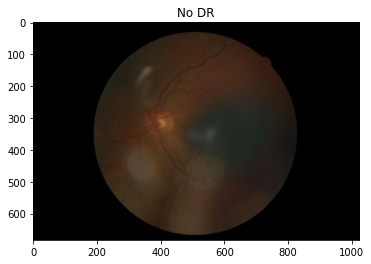

In [ ]:
## non-proliferative diabetic retinopathy
test_img = glob.glob('/content/0/*jpeg')
img_select = random.randint(1,len(test_img))
img = plt.imread(test_img[img_select])
plt.imshow(img)
plt.title(Classes_Name[0])

Text(0.5, 1.0, 'Mild')

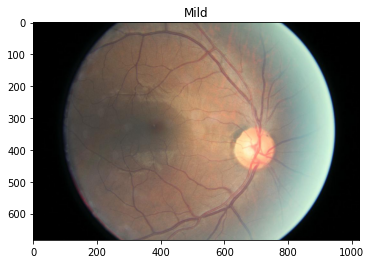

In [ ]:
#proliferative diabetic retinopathy
test_img = glob.glob('/content/1/*jpeg')
img_select = random.randint(1,len(test_img))
img = plt.imread(test_img[img_select])
plt.imshow(img)
plt.title(Classes_Name[1])

Text(0.5, 1.0, 'Moderate')

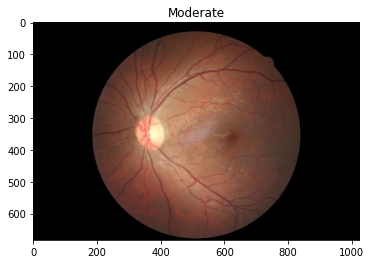

In [ ]:
test_img = glob.glob('/content/2/*jpeg')
img_select = random.randint(1,len(test_img))
img = plt.imread(test_img[img_select])
plt.imshow(img)
plt.title(Classes_Name[2])

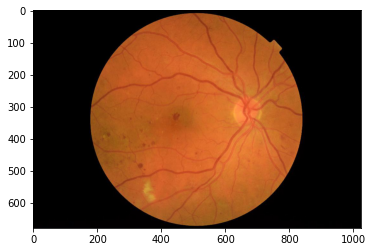

In [ ]:
test_img = glob.glob('/content/3/*jpeg')
img_select = random.randint(1,len(test_img))
img = plt.imread(test_img[img_select])
plt.imshow(img)
plt.title(Classes_Name[3])

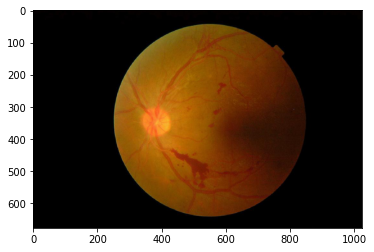

In [ ]:
test_img = glob.glob('/content/4/*jpeg')
img_select = random.randint(1,len(test_img))
img = plt.imread(test_img[img_select])
plt.imshow(img)
plt.title(Classes_Name[4])

In [ ]:
#Arrange Data Into One System  - Rearranging the data in 
!mkdir dataset 
!mv "/content/0" "/content/dataset"
!mv "/content/1" "/content/dataset"
!mv "/content/2" "/content/dataset"
!mv "/content/3" "/content/dataset"
!mv "/content/4" "/content/dataset"